# Compare compartment with comethylation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
import cooler
import hba_data
from itertools import cycle, islice
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from concurrent.futures import ProcessPoolExecutor, as_completed

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/data/hba/compartment_majortype/'
outdir = '/home/jzhou_salk_edu/sky_workdir/hba/compartment_majortype/'


In [3]:
leg = ['L23_IT', 'L4_IT', 'L56_NP', 'L5_ET', 'L5_IT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'L6b', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 
       'MSN_D1', 'MSN_D2', 'SubCtx', 'Amy', 'CHD7', 'Foxp2', 
       'ASC', 'ODC', 'OPC', 'MGC', 'EC', 'PC', 'VLMC', 'merged']
legname = ['L2/3-IT', 'L4-IT', 'L5/6-NP', 'L5-ET', 'L5-IT', 'L6-CT', 'L6-IT', 'L6-IT-Car3', 'L6b', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 
       'MSN-D1', 'MSN-D2', 'SubCtx-Cplx', 'Amy-Exc', 'Chd7', 'Foxp2', 
       'ASC', 'ODC', 'OPC', 'MGC', 'EC', 'PC', 'VLMC', 'merged'
      ]


In [4]:
res = 100000
chrom_size_path = '/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:23]


In [6]:
mode = 'raw'
comp = pd.read_hdf(f'{outdir}comp_{mode}_mergerawpca.hdf', key='data')
comp

,L5_ET,L56_NP,L23_IT,L4_IT,L6_IT,L6b,L5_IT,L6_IT_Car3,Lamp5,L6_CT,...,CHD7,Foxp2,OPC,ODC,ASC,VLMC,EC,PC,MGC,merged
chr1-18,1.262724,4.745961,4.532953,6.074816,4.385525,3.601142,5.044535,4.745368,7.021493,5.241165,...,6.350878,5.443851,8.545128,6.479689,6.038124,7.010916,6.193613,7.818554,10.942541,7.573896
chr1-19,1.421160,5.227821,4.742626,6.077094,4.640529,4.122677,5.186667,4.969541,7.254596,5.666524,...,7.296734,5.656314,9.275956,6.942686,6.461882,6.664307,6.530445,7.721279,11.769346,7.503558
chr1-20,1.552144,4.720595,4.882112,6.625833,4.805314,4.070691,5.603995,5.319397,6.953638,5.743913,...,7.294498,5.555722,9.471356,7.392001,6.827351,6.832435,6.113659,7.430872,11.617200,7.445576
chr1-21,1.347600,4.495035,4.409264,6.373844,4.654892,3.944247,5.239480,4.584552,7.050535,5.593628,...,6.668277,5.345105,8.932059,7.566949,6.756874,6.692109,6.573919,7.774136,12.227214,7.487518
chr1-22,1.239676,4.606086,4.792674,6.327627,4.451870,3.724550,5.004744,4.469162,6.561917,5.532068,...,6.683668,5.515938,9.066686,7.454593,6.677850,6.736316,6.756169,7.914874,11.302973,7.543835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22-498,-0.642383,-0.193310,-0.167683,0.066275,0.063709,-0.012046,-0.007180,-0.003458,0.369045,0.075564,...,0.219480,-0.721090,-0.335253,2.386674,-0.508691,-0.067209,0.128222,0.416390,2.522928,1.139465
chr22-499,-0.876948,-0.211688,0.374943,0.841765,0.760642,0.422578,0.673747,0.462583,0.794520,0.835991,...,0.490132,-0.535043,0.173314,4.393894,0.742954,1.703635,1.213310,1.763509,4.390028,2.549865
chr22-500,-0.884130,-0.240891,-0.451213,0.072616,0.411017,-0.067791,0.192176,-0.222203,0.034812,0.114169,...,0.084431,-0.478074,-1.168219,-0.538458,0.289802,1.063949,-0.305873,-2.942465,1.133707,0.564305
chr22-501,-0.659747,-0.046996,0.402952,1.649726,1.054437,0.437586,1.195990,0.106239,1.438901,0.905608,...,1.076683,-0.238773,0.114526,1.622971,0.962307,1.536778,0.257000,-0.837970,4.747499,2.990559


## mCG

In [7]:
def saddle(cool, comp):
    sad = np.zeros((50, 50))
    count = np.zeros((50, 50))
    for chrom in chrom_sizes.index[:-1]:
        Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
        Q = Q - np.diag(np.diag(Q))
        pc = comp.loc[(comp.index.str.split('-').str[0]==chrom)]
        pc.index = [int(xx.split('-')[1]) for xx in pc.index]
        Q = Q[np.ix_(pc.index, pc.index)]
        labels, groups = pd.qcut(pc, 50, labels=False, retbins=True)
        sad += np.array([[Q[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count += np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
    return sad, count


In [8]:
sad = np.zeros((len(leg),50,50))
count = np.zeros((len(leg),50,50))


In [9]:
cpu = 10
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for t,ct in enumerate(leg):
        cool = cooler.Cooler(f'{indir}{ct}/{ct}.CGcorr.cool')
        future = executor.submit(
            saddle,
            cool=cool,
            comp=comp[ct],
        )
        futures[future] = t

    for future in as_completed(futures):
        t = futures[future]
        yy, zz = future.result()
        sad[t] += yy
        count[t] += zz
        print(f'{leg[t]} finished')
        

L5_IT finished
L23_IT finished
L4_IT finished
L6_IT_Car3 finished
L56_NP finished
L6_IT finished
L5_ET finished
Lamp5 finished
L6_CT finished
L6b finished
Lamp5_LHX6 finished
Sncg finished
Pvalb finished
Sst finished
Vip finished
Pvalb_ChC finished
MSN_D1 finished
MSN_D2 finished
SubCtx finished
Amy finished
ASC finished
CHD7 finished
Foxp2 finished
MGC finished
EC finished
PC finished
ODC finished
OPC finished
VLMC finished
merged finished


In [10]:
sad = sad / count
np.save(f'{outdir}saddle_{mode}_mergerawpca_CGcorr.npy', sad)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


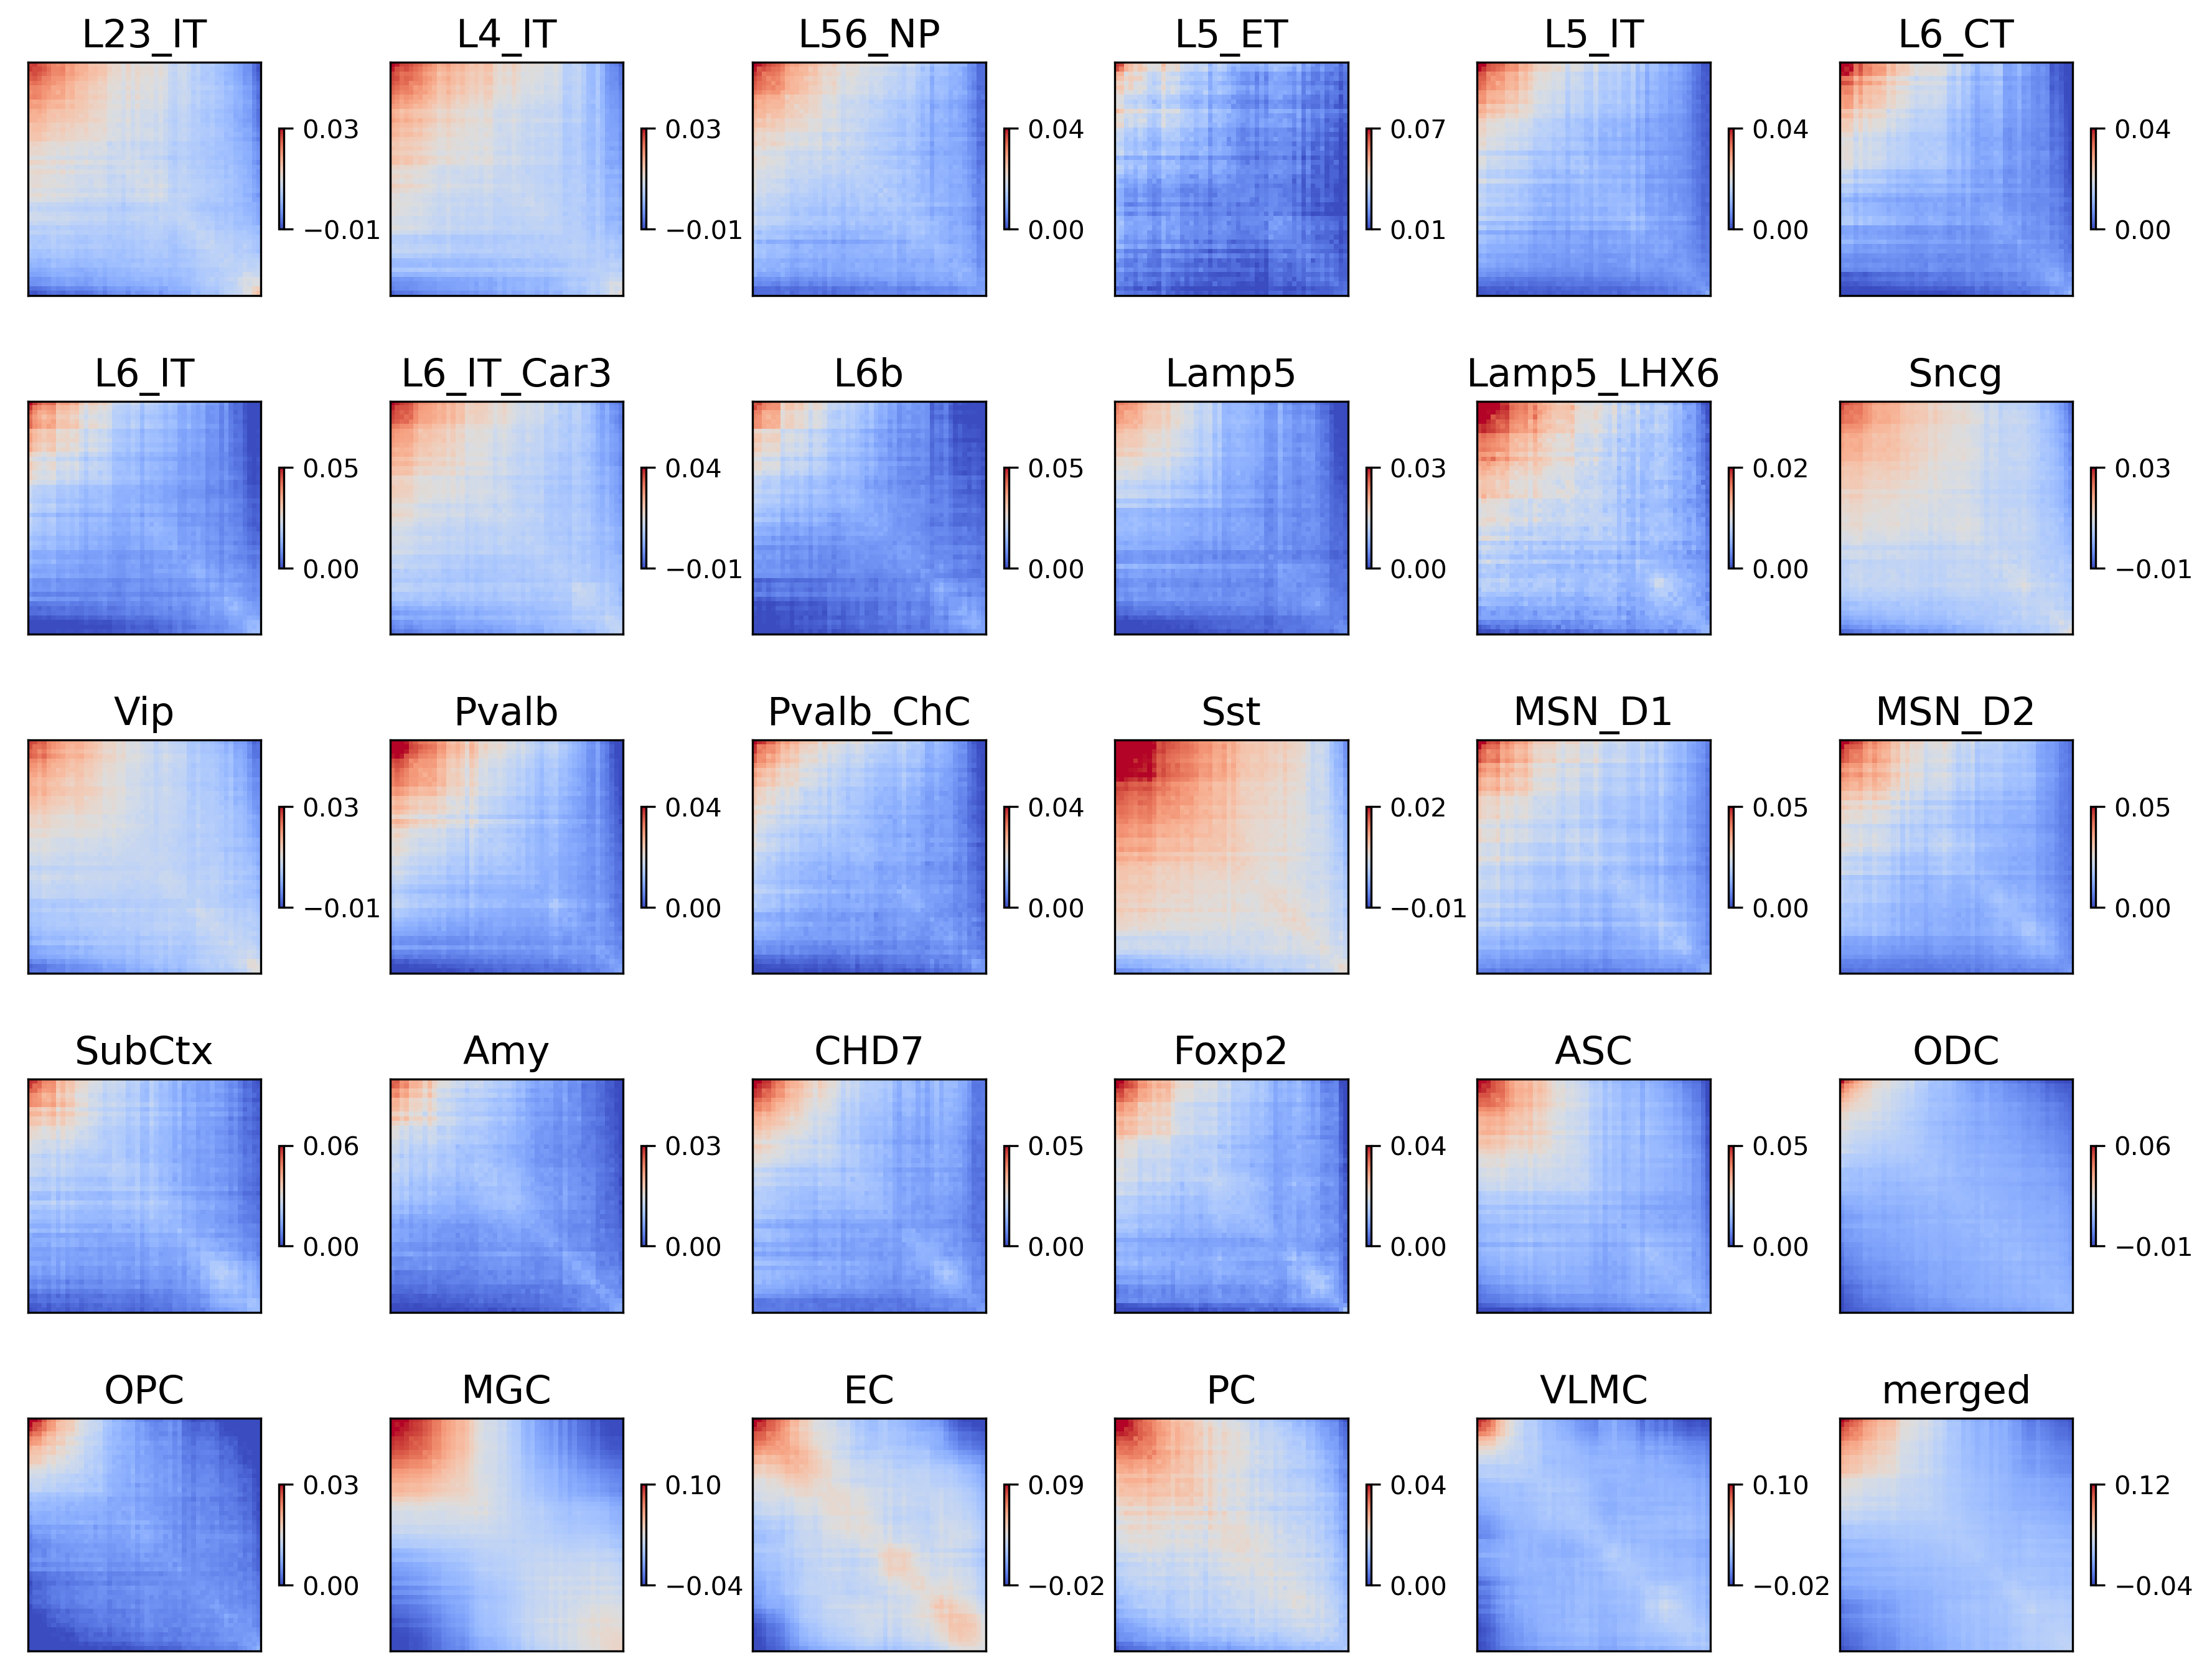

In [11]:
# raw
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(((len(leg)-1)//6+1), 6, figsize=(15,12), gridspec_kw={'wspace':0.01}, dpi=300)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i,xx in enumerate(leg):
    ax = axes.flatten()[i]
    # plot = ax.imshow(np.log2(sad[i]+0.001), cmap='coolwarm', vmin=vmin, vmax=vmax)
    plot = ax.imshow(sad[i], cmap='coolwarm')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(xx, fontsize=15)
    # ax.text(24.5, 24.5, np.around(compstr.loc[xx, 'strength'], decimals=3), ha='center', va='center', fontsize=15)
    cbar = plt.colorbar(plot, ax=ax, shrink=0.3, fraction=0.3)
    plot.set_clim(np.around([cbar.vmin, cbar.vmax], decimals=2))
    cbar.set_ticks([cbar.vmin, cbar.vmax])
    
# cbar = plt.colorbar(plot, ax=axes.flatten()[len(leg)])
# cbar.set_ticks([vmin,vmax])
# cbar.set_label('CG corr')

for ax in axes.flatten()[len(leg):]:
    ax.axis('off')
    
# plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_saddle_impute.pdf', transparent=True)


## mCH

In [12]:
sad = np.zeros((len(leg),50,50))
count = np.zeros((len(leg),50,50))


In [13]:
cpu = 10
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for t,ct in enumerate(leg):
        cool = cooler.Cooler(f'{indir}{ct}/{ct}.CHcorr.cool')
        future = executor.submit(
            saddle,
            cool=cool,
            comp=comp[ct],
        )
        futures[future] = t

    for future in as_completed(futures):
        t = futures[future]
        yy, zz = future.result()
        sad[t] += yy
        count[t] += zz
        print(f'{leg[t]} finished')
        

L23_IT finished
L5_IT finished
L5_ET finished
L56_NP finished
L6_CT finished
L4_IT finished
L6_IT_Car3 finished
L6b finished
Lamp5 finished
L6_IT finished
Lamp5_LHX6 finished
Sst finished
Sncg finished
Vip finished
Pvalb finished
MSN_D1 finished
Pvalb_ChC finished
MSN_D2 finished
Amy finished
SubCtx finished
ASC finished
CHD7 finished
Foxp2 finished
ODC finished
OPC finished
MGC finished
EC finished
PC finished
merged finished
VLMC finished


In [14]:
sad = sad / count
np.save(f'{outdir}saddle_{mode}_mergerawpca_CHcorr.npy', sad)


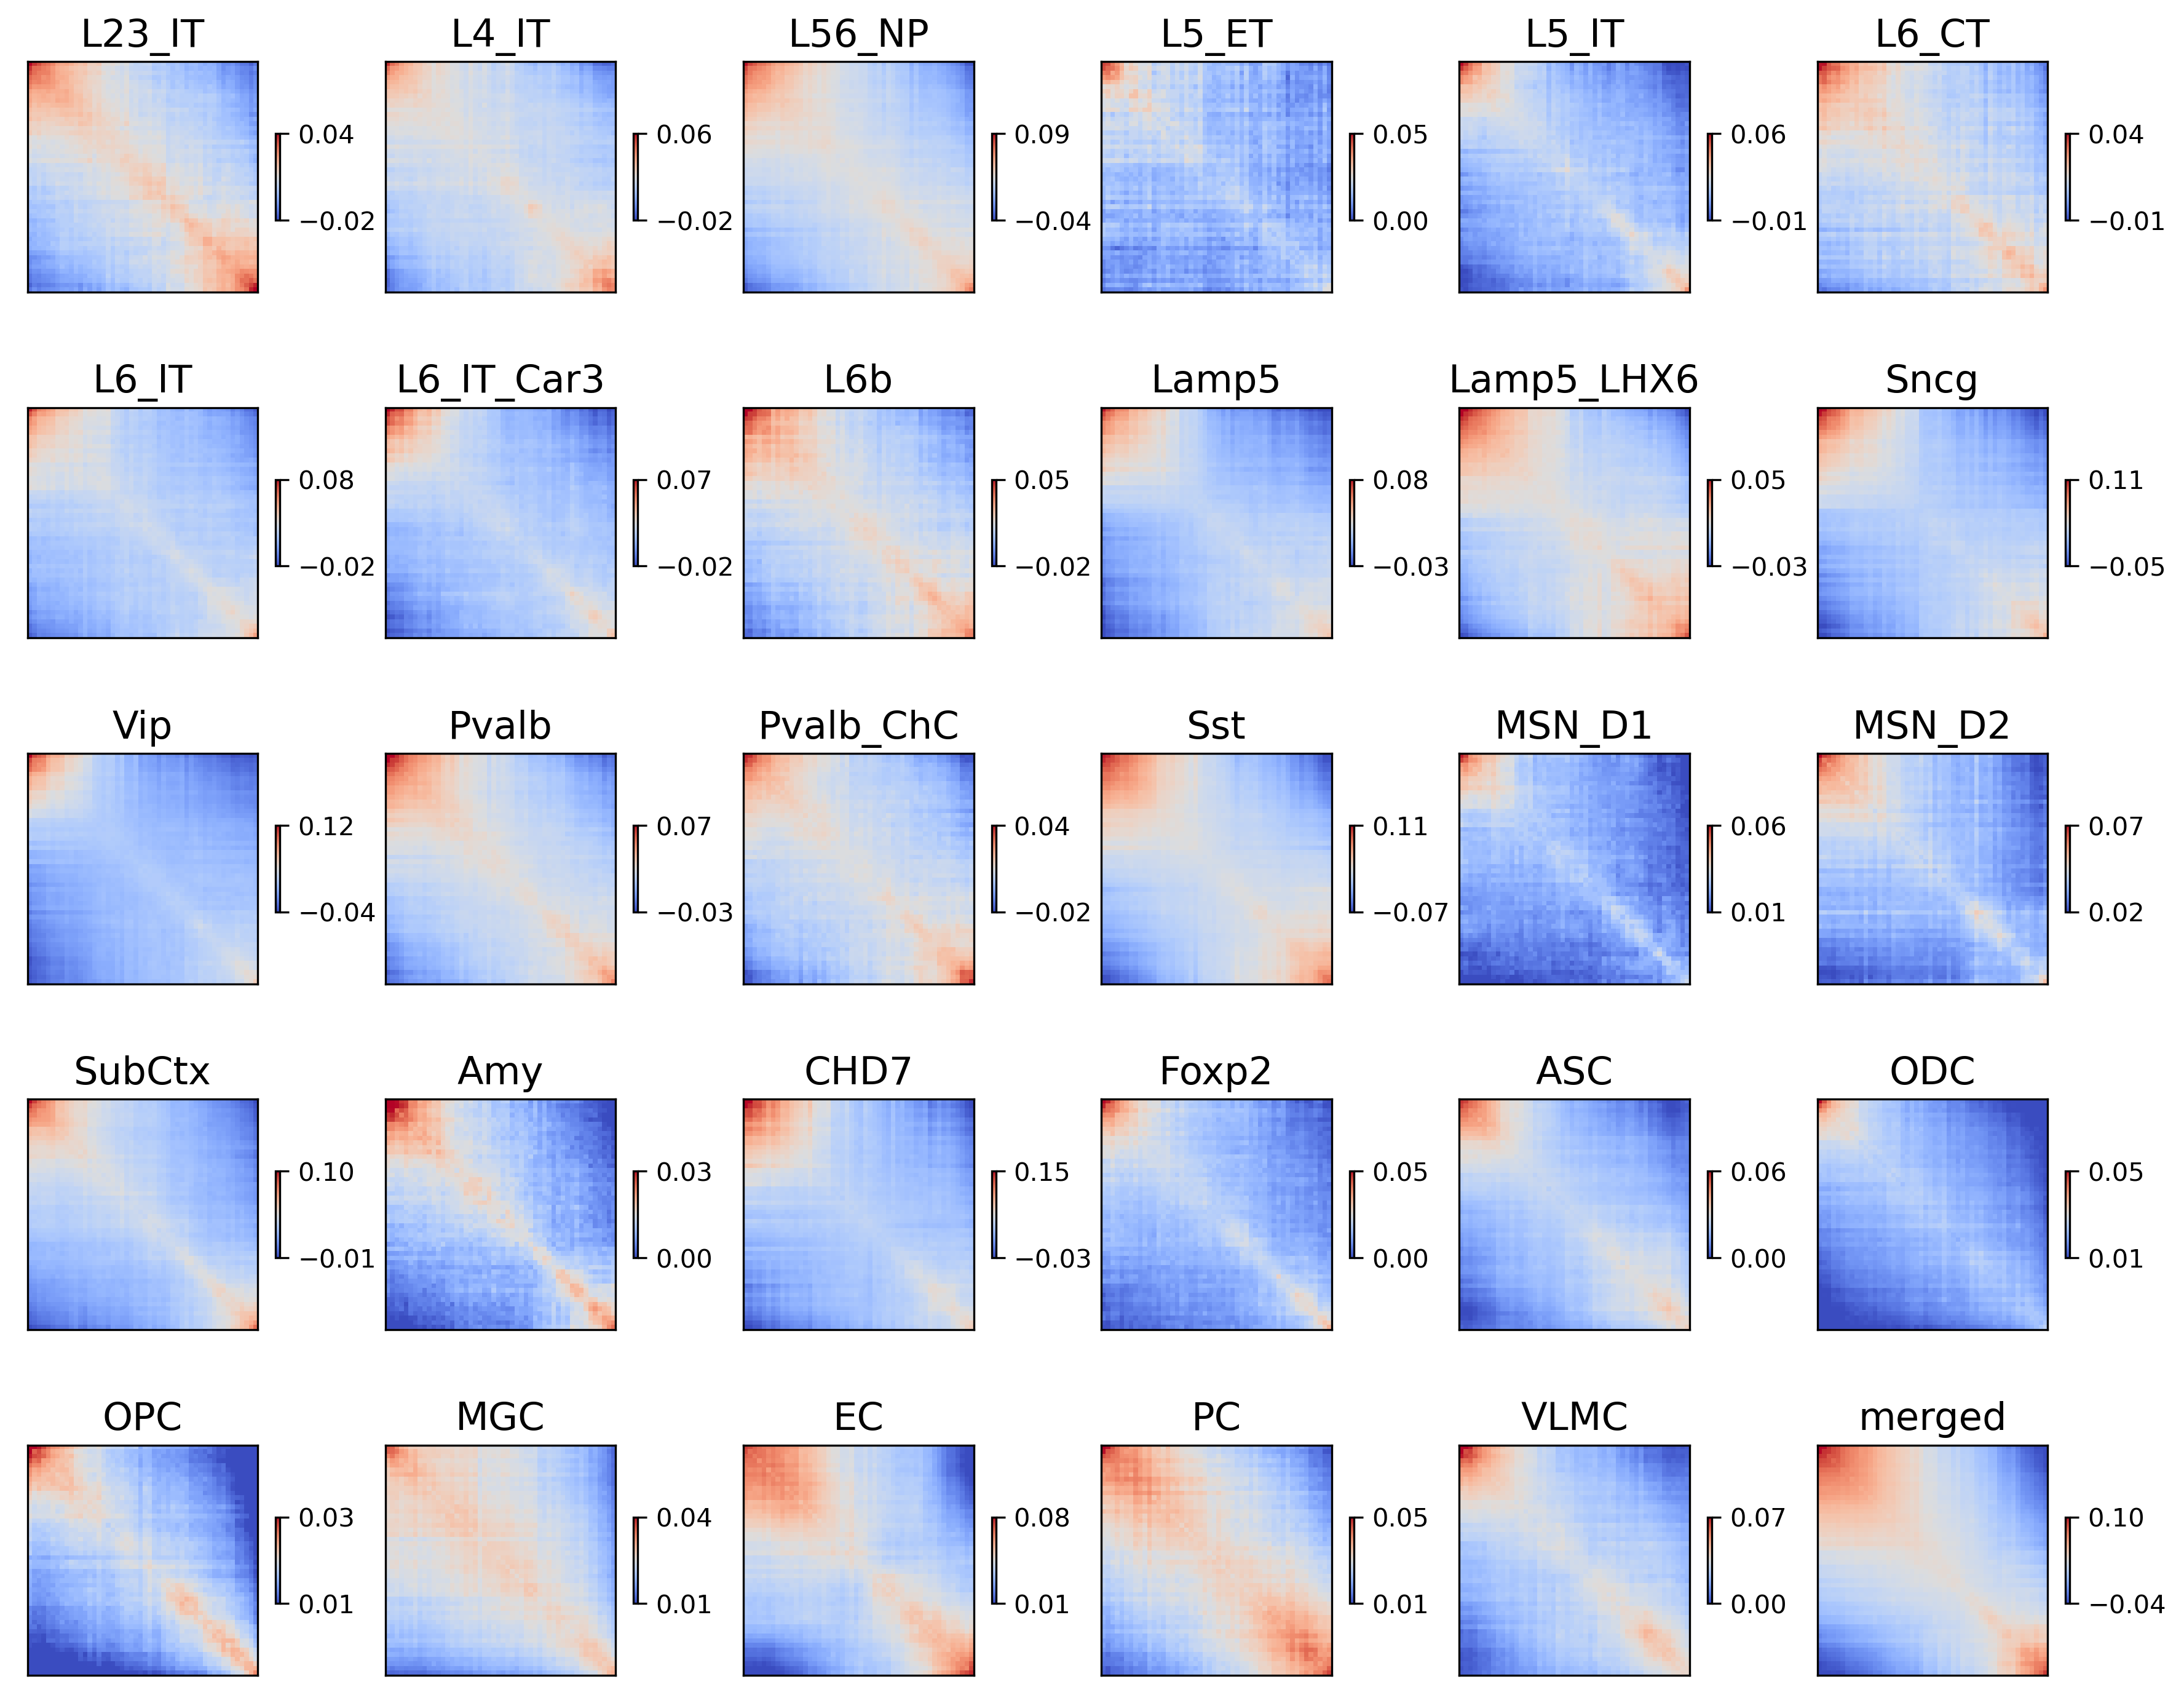

In [15]:
# raw
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(((len(leg)-1)//6+1), 6, figsize=(15,12), gridspec_kw={'wspace':0.01}, dpi=300)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
for i,xx in enumerate(leg):
    ax = axes.flatten()[i]
    # plot = ax.imshow(np.log2(sad[i]+0.001), cmap='coolwarm', vmin=vmin, vmax=vmax)
    plot = ax.imshow(sad[i], cmap='coolwarm')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(xx, fontsize=15)
    # ax.text(24.5, 24.5, np.around(compstr.loc[xx, 'strength'], decimals=3), ha='center', va='center', fontsize=15)
    cbar = plt.colorbar(plot, ax=ax, shrink=0.3, fraction=0.3)
    plot.set_clim(np.around([cbar.vmin, cbar.vmax], decimals=2))
    cbar.set_ticks([cbar.vmin, cbar.vmax])
    
# cbar = plt.colorbar(plot, ax=axes.flatten()[len(leg)])
# cbar.set_ticks([vmin,vmax])
# cbar.set_label('CG corr')

for ax in axes.flatten()[len(leg):]:
    ax.axis('off')
    
# plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_saddle_impute.pdf', transparent=True)
